In [2]:
%pip install torch

  Obtaining dependency information for torch from https://files.pythonhosted.org/packages/0b/fa/f33a4148c6fb46ca2a3f8de39c24d473822d5774d652b66ed9b1214da5f7/torch-2.6.0-cp311-none-macosx_11_0_arm64.whl.metadata
  Obtaining dependency information for sympy==1.13.1 from https://files.pythonhosted.org/packages/b2/fe/81695a1aa331a842b582453b605175f419fe8540355886031328089d840a/sympy-1.13.1-py3-none-any.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.5/66.5 MB 6.0 MB/s eta 0:00:0000:0100:01m
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.2/6.2 MB 3.8 MB/s eta 0:00:0000:0100:01m
  Attempting uninstall: sympy
    Found existing installation: sympy 1.13.2
    Uninstalling sympy-1.13.2:
      Successfully uninstalled sympy-1.13.2
Note: you may need to restart the kernel to use updated packages.


In [9]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

In [4]:
class LANDModel(nn.Module):
    def __init__(self, Na=512, Nb=1024, Drate=0.45):
        super(LANDModel, self).__init__()

        # Local DEM branch
        self.local_dense1 = nn.Linear(25, 128)
        self.local_dense2 = nn.Linear(128, 128)

        # Regional DEM branch
        self.regional_dense1 = nn.Linear(25, 128)
        self.regional_dense2 = nn.Linear(128, 128)

        # Month one-hot (12D)
        self.month_dense = nn.Linear(12, 128)

        # Reanalysis data branch (16 channels, 3x3)
        self.reanalysis_conv = nn.Conv2d(in_channels=16, out_channels=Na, kernel_size=3, groups=16)
        self.reanalysis_flat = nn.Flatten()
        self.reanalysis_dense1 = nn.Linear(Na, Na)
        self.reanalysis_dense2 = nn.Linear(Na, Na)

        # Final combined layers
        self.combined_dense1 = nn.Linear(384 + Na, Nb)
        self.bn1 = nn.BatchNorm1d(Nb)
        self.combined_dense2 = nn.Linear(Nb, Nb)
        self.bn2 = nn.BatchNorm1d(Nb)
        self.dropout = nn.Dropout(p=Drate)
        self.output_layer = nn.Linear(Nb, 1)

    def forward(self, local_dem, regional_dem, month_onehot, reanalysis):
        # Local DEM path
        x_local = F.relu(self.local_dense1(local_dem))
        x_local = F.relu(self.local_dense2(x_local))

        # Regional DEM path
        x_regional = F.relu(self.regional_dense1(regional_dem))
        x_regional = F.relu(self.regional_dense2(x_regional))

        # Month one-hot path
        x_month = F.relu(self.month_dense(month_onehot))

        # Reanalysis path
        x_reanalysis = F.relu(self.reanalysis_conv(reanalysis))  # shape: [batch, Na, 1, 1]
        x_reanalysis = torch.flatten(x_reanalysis, start_dim=1)
        x_reanalysis = F.relu(self.reanalysis_dense1(x_reanalysis))
        x_reanalysis = F.relu(self.reanalysis_dense2(x_reanalysis))

        # Concatenate all
        x = torch.cat([x_local, x_regional, x_month, x_reanalysis], dim=1)

        # Final MLP
        x = F.relu(self.bn1(self.combined_dense1(x)))
        x = F.relu(self.bn2(self.combined_dense2(x)))
        x = self.dropout(x)
        x = F.relu(self.output_layer(x))

        return x

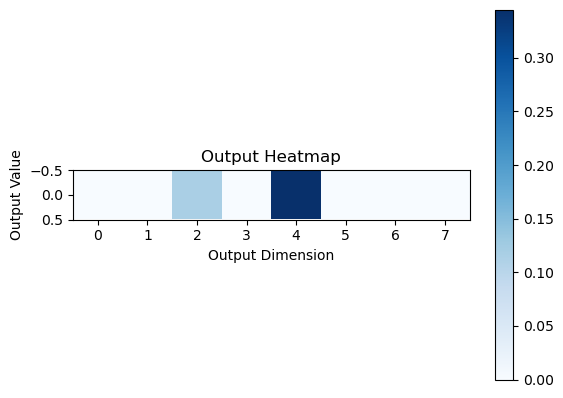

In [13]:
model = LANDModel()

# Expected data format and description:
# local_dem: [batch, 25]: Local DEM features
# regional_dem: [batch, 25]: Regional DEM features
# month_onehot: [batch, 12]: Month one-hot encoded features
# reanalysis: [batch, 16, 3, 3]: 16 climate variables of 3x3 reanalysis data

# dummy inputs
local = torch.rand(8, 25)
regional = torch.rand(8, 25)
month = torch.eye(12)[torch.randint(0, 12, (8,))]  # batch=8
rean = torch.rand(8, 16, 3, 3)

# prediction
out = model(local, regional, month, rean)

# plot the out as a 2D image
plt.imshow(out.detach().numpy().reshape(1, -1), cmap='Blues', interpolation='nearest')
plt.colorbar()
plt.title('Output Heatmap')
plt.xlabel('Output Dimension')
plt.ylabel('Output Value')
plt.show()